--- 4D 纠错动力学模拟 ---
Lattice: 6^4, Steps: 5000
Running Low Temp (Correction)...
Running High Temp (Noise)...
图表已生成: correction_dynamics.png


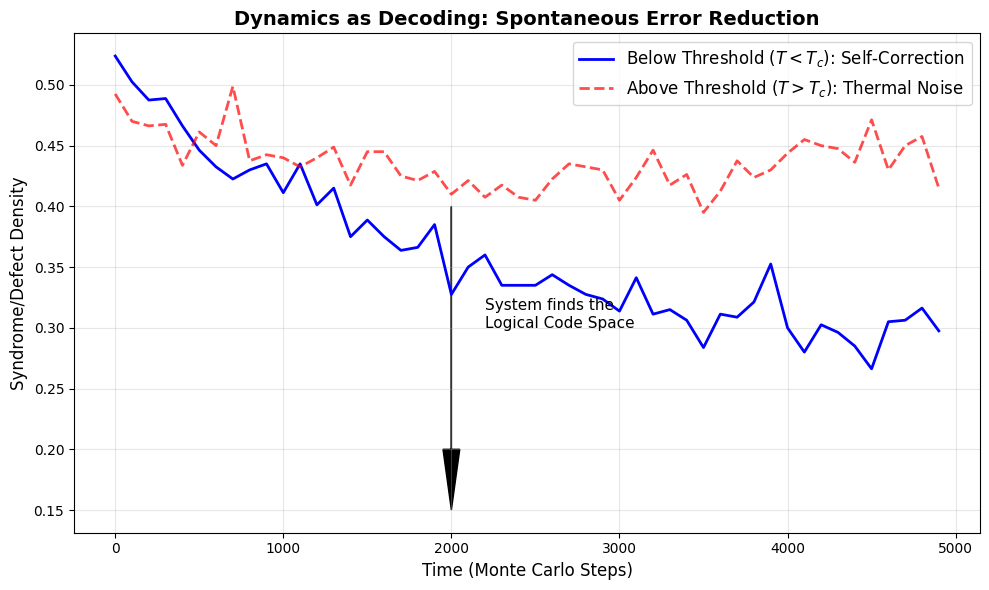

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- 参数 ---
L = 6       # 4D 格点大小 6^4 = 1296
N = L**4
T_LOW = 0.5 # 低温 (记忆相)
T_HIGH = 5.0 # 高温 (错误相)
STEPS = 5000 # 蒙特卡洛步数

print(f"--- 4D 纠错动力学模拟 ---")
print(f"Lattice: {L}^4, Steps: {STEPS}")

# 1. 初始化 4D 莫比乌斯耦合 J_uv
# 使用确定性哈希模拟
def get_J(u, v):
    h = (u * 12345 + v * 67890) ^ 0xAB
    return 1.0 if (h % 2 == 0) else -1.0

# 构建邻居表 (PBC)
neighbors = [[] for _ in range(N)]
for u in range(N):
    # 解码坐标
    x, y, z, w = u%L, (u//L)%L, (u//L**2)%L, (u//L**3)%L
    # 找邻居
    for d, pos in enumerate([x, y, z, w]):
        # 正方向
        coord_next = [x, y, z, w]
        coord_next[d] = (pos + 1) % L
        v = coord_next[0] + coord_next[1]*L + coord_next[2]*L**2 + coord_next[3]*L**3
        neighbors[u].append((v, get_J(u, v)))
        # 负方向 (确保对称)
        coord_prev = [x, y, z, w]
        coord_prev[d] = (pos - 1) % L
        v_prev = coord_prev[0] + coord_prev[1]*L + coord_prev[2]*L**2 + coord_prev[3]*L**3
        neighbors[u].append((v_prev, get_J(u, v_prev)))

def run_relaxation(temperature):
    # 2. 初始状态：完全随机 (Hot Start, Full of Errors)
    spins = np.random.choice([-1, 1], size=N)

    defect_density_history = []

    # 3. Metropolis 演化 (模拟最小作用量解码)
    for t in range(STEPS):
        # 随机选一个点尝试翻转
        i = np.random.randint(0, N)

        # 计算能量差 dE = 2 * s_i * sum(J_ij * s_j)
        local_field = sum(J * spins[j] for j, J in neighbors[i])
        dE = 2 * spins[i] * local_field

        # Metropolis 准则
        if dE < 0 or np.random.rand() < np.exp(-dE / temperature):
            spins[i] *= -1 # 翻转

        # 记录当前不满足 J*s*s > 0 的键的比例)
        # 每 100 步采样一次
        if t % 100 == 0:
            # 抽样计算总能量/不满意度
            # 简化计算：只算部分格点作为代理指标
            sample_indices = np.random.randint(0, N, size=100)
            defects = 0
            total_checks = 0
            for k in sample_indices:
                for n_idx, J in neighbors[k]:
                    if J * spins[k] * spins[n_idx] < 0: # Frustrated link
                        defects += 1
                    total_checks += 1
            defect_density_history.append(defects / total_checks)

    return defect_density_history

# --- 运行对比 ---
print("Running Low Temp (Correction)...")
history_low = run_relaxation(T_LOW)

print("Running High Temp (Noise)...")
history_high = run_relaxation(T_HIGH)

# --- 绘图 ---
plt.figure(figsize=(10, 6))
time_axis = np.arange(len(history_low)) * 100

plt.plot(time_axis, history_low, 'b-', linewidth=2, label=r'Below Threshold ($T < T_c$): Self-Correction')
plt.plot(time_axis, history_high, 'r--', linewidth=2, alpha=0.7, label=r'Above Threshold ($T > T_c$): Thermal Noise')

plt.xlabel('Time (Monte Carlo Steps)', fontsize=12)
plt.ylabel('Syndrome/Defect Density', fontsize=12)
plt.title('Dynamics as Decoding: Spontaneous Error Reduction', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 标注
plt.arrow(2000, 0.4, 0, -0.2, head_width=100, head_length=0.05, fc='k', ec='k')
plt.text(2200, 0.3, "System finds the\nLogical Code Space", fontsize=11)

plt.tight_layout()
plt.savefig('correction_dynamics.png', dpi=300)
print("图表已生成: correction_dynamics.png")